In [61]:
#import modules
import matplotlib.pyplot as plt, numpy as np, math
from matplotlib.patches import Rectangle
from datetime import datetime
import GUI_test

In [62]:
#constants:

HOME = 'G28'        #this is a custom saved location
positioning = 'G90' #absolute positioning
units = 'G21'       #everything using mm

#settings:
material = 'PCL'    #purely informational, does not affect printer function
printer = 'Voron'   #purely informational
nozzle_temp = 230   #C probably depends on material...
bed_temp = 35       #C sometimes will get stuck if above 40

#platform limits(be aware that it could go over if inaccurate)
x_max = 120     #mm
y_max = 120     #mm

#Line Settings: How wide and tall for the box of lines: in mm
product_width = 60  #mm SHOULD NOT BE GREATER THAN X_MAX
product_height = 60 #mm SHOULD NOT BE GREATER THAN Y_MAX
num_groups = 5     #number of line groups - consecutive lines made with same speed
line_per_group = 1  #mm gap between lines of the same line group
ratio_of_dxgroup_dxline = 3 #ratio between distance between lines and distance between groups of lines so dxg/dxl

#for incrementing pts only:
pts_per_line = 5    #mm Choose 1mm if you want each whole line representing one speed.

#testing all feeding speeds within range:
nozzle_v_min = 0.2      #mm/min
nozzle_v_max = 1       #mm/min
nozzle_v_cap = 5       #mm/min

velocity_of_nozzle = 400    #mm/min
velocity_of_nozzle_cap = 800    #mm/min
bed_dist = 0.5  #mm


collagen = 0    #new material
flathead = 0    #new nozzle

flathead_nozzle_width = 10   #mm

gear_ratio_constant = -8.343 #mm/mm obtained from gear_calc.ipynb
cylinder_length_per_volume = 5.53   #obtain from measuring distance between syringe indents mm/ml
mm_stepper_per_ml_syringe = cylinder_length_per_volume/gear_ratio_constant  #mm_stepper/ml_syringe
print(mm_stepper_per_ml_syringe)

-0.6628311159055496


In [63]:
#trigger GUI
#rly rly janky ;-;

list = [product_width, product_height, num_groups, line_per_group, nozzle_v_min, nozzle_v_max, velocity_of_nozzle, collagen, flathead]
    
while(True):
    try:
        instream = GUI_test.run_GUI()
        for index in range(len(instream)):
            if(instream[index] != -1):
                list[index] = instream[index]
    except ValueError:
        "Potential Value Error"
    if(product_height <= y_max and product_width <= x_max and velocity_of_nozzle <= velocity_of_nozzle_cap and nozzle_v_max <= nozzle_v_cap and nozzle_v_min <= nozzle_v_cap):
        break

product_width, product_height, num_groups, line_per_group, nozzle_v_min, nozzle_v_max, velocity_of_nozzle, collagen, flathead = list
    #these r limits

Using Local CTS Settings
Empty input.


In [64]:
#Calculations:
dx_line = product_width/(num_groups*(line_per_group-1)+ratio_of_dxgroup_dxline*(num_groups-1))
print(f"Distance between lines: {dx_line}mm")
dx_group = dx_line*ratio_of_dxgroup_dxline
print(f"Distane between groups: {dx_group}mm")
nozzle_dv = (nozzle_v_max-nozzle_v_min)/num_groups   #mm/s

if flathead:
    line_per_group = 1

Distance between lines: 5.0mm
Distane between groups: 15.0mm


In [65]:
#Coordinate plotting:
input_coordinate = []

#Get beginning location: gotta find it

#use for nxn product
def get_coordinate_init_centered():
    #always want the product to be centered, cannot go beyond the limit
    coord_init = np.array([x_max-product_width,y_max-product_height])/2
    return coord_init
    
#use for all else
def get_coordinate_init_cornered():
    #will just be lower left corner
    return [10,10]

if(product_width == product_height):coord_init = get_coordinate_init_centered()
else: coord_init = get_coordinate_init_cornered()

#generate rough lines, then can populate new coordinate list with linspaced points for increments

def find_next_pt(input, viable_opt):
    if(input == viable_opt[0]):
        return viable_opt[1]
    return viable_opt[0]

#generating lines w/out increment:
input_coordinate.append(coord_init)
for group in range(int(num_groups)):
    options = [coord_init[1], coord_init[1]+product_height]
    for line in range(int(line_per_group)):
        
        current_x = (input_coordinate[-1])[0]
        current_y = (input_coordinate[-1])[1]
        next_pt = [current_x,find_next_pt(current_y,options)]
        input_coordinate.append(next_pt)
        
        if line != line_per_group-1:
            current_x = (input_coordinate[-1])[0]
            current_y = (input_coordinate[-1])[1]
            next_pt = [current_x+dx_line, current_y]
            input_coordinate.append(next_pt)
        
    current_x = (input_coordinate[-1])[0]
    current_y = (input_coordinate[-1])[1]
    if group != num_groups-1:
        input_coordinate.append([current_x+dx_group,current_y])

input_coordinate = np.array(input_coordinate)
#print(input_coordinate)
print(len(input_coordinate))

10


Text(0.5, 1.0, 'vector form')

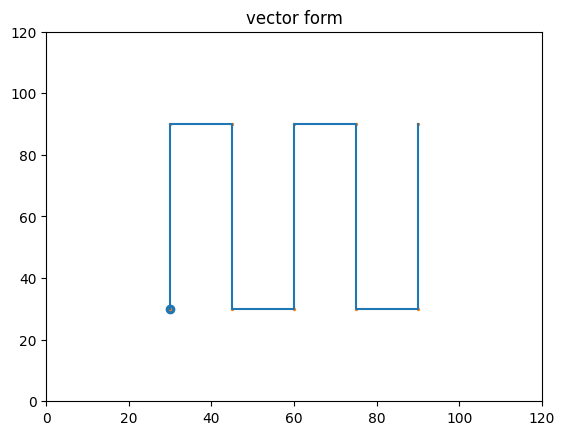

In [66]:
#graph points
plt.scatter(input_coordinate[0][0],input_coordinate[0][1])
x = input_coordinate[:,0]
y = input_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
plt.scatter(x,y, s=2)
plt.title("vector form")

In [67]:
#incrementize coordinates:
spliced_coordinate = np.array([coord_init])
list_of_boxes = []

def splice_vector_into_pts(xy_init, xy_final, pts_per_line):
    result = np.linspace(xy_init,xy_final,pts_per_line)
    return result

for set in range(0, len(input_coordinate)-1, 2):
    spliced_vector = splice_vector_into_pts(input_coordinate[set],input_coordinate[set+1],int(pts_per_line))
    spliced_coordinate = np.concatenate((spliced_coordinate,spliced_vector),axis=0)
    if(flathead):
        box = Rectangle((input_coordinate[set][0]-flathead_nozzle_width/2,input_coordinate[set][1]), (flathead_nozzle_width), (input_coordinate[set+1][1]-input_coordinate[set][1]), facecolor = "none", edgecolor = "red")
        list_of_boxes.append(box)
    

spliced_coordinate = np.delete(spliced_coordinate,0,0)

#print(spliced_coordinate)
print(f"Pts: {len(spliced_coordinate)}")

Pts: 25


Text(0.5, 1.0, 'spliced')

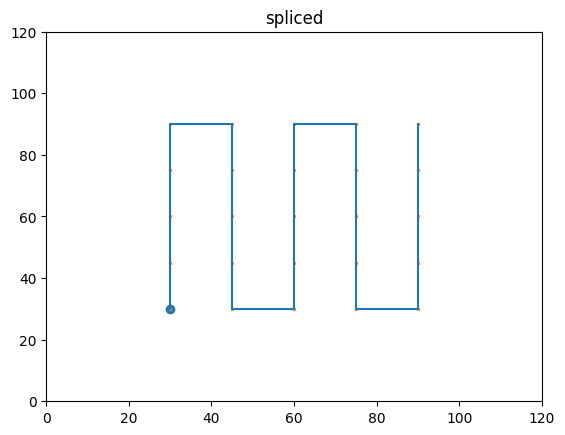

In [68]:
#graph points of splice (should look the same as previous graph)
plt.scatter(spliced_coordinate[0][0],spliced_coordinate[0][1])
x = spliced_coordinate[:,0]
y = spliced_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
ax = plt.gca()
for box in list_of_boxes:
    ax.add_patch(box)
plt.scatter(x,y, s=2)
plt.title("spliced")

In [69]:
#create array for each point's speed
speed_corresponding_to_spliced_coord = np.linspace(nozzle_v_min,nozzle_v_max,len(spliced_coordinate))*mm_stepper_per_ml_syringe
#print(speed_corresponding_to_spliced_coord)
print(len(speed_corresponding_to_spliced_coord))
print(f"Material Usage: {nozzle_v_max-nozzle_v_min}mm")

25
Material Usage: 0.8mm


Text(0.5, 0, 'Distance Traveled [mm]')

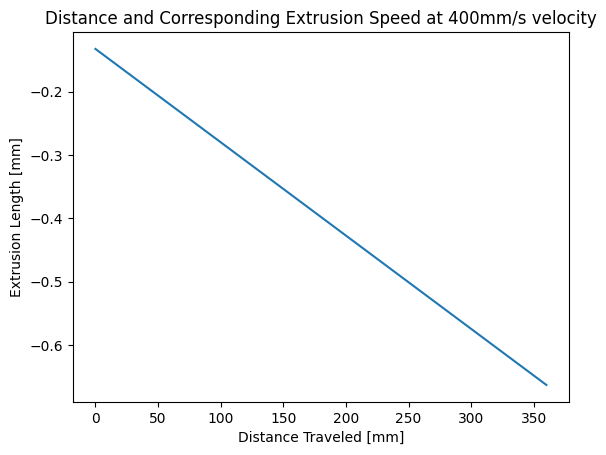

In [70]:
#Translate coordinates to distance:

distance = [0]
distance_traveled = 0
extrusion_length = speed_corresponding_to_spliced_coord

for index in range(1, len(spliced_coordinate), 1):
    distance_traveled += (math.dist(spliced_coordinate[index-1], spliced_coordinate[index]))
    distance.append(distance_traveled)

plt.plot(distance, extrusion_length)
plt.title(f"Distance and Corresponding Extrusion Speed at {velocity_of_nozzle}mm/s velocity")
plt.ylabel("Extrusion Length [mm]")
plt.xlabel("Distance Traveled [mm]")

#this depends on if we are using M83 or M82 since if its absolute, the last step will correspond to how much in total is used.
#print(f"Total Material Used(rounded): {round(sum(extrusion_length)*mm_stepper_per_ml_syringe,3)} grams")

In [71]:
#gcode writer that will combine coordinate information and speed information
def get_gcode_block(position, fillament_speed):
    return f"G1 X{position[0]} Y{position[1]} Z{bed_dist} E{fillament_speed}"

def get_gcode_block_movement_only(position, filament_speed):
     return f"G1 X{position[0]} Y{position[1]} Z{bed_dist}"

In [72]:
#create file:

file_name = input("Enter file name: ")
if(len(file_name) > 1): 
        with open(str(file_name) + ".gcode", "w") as f:
        #description
                f.write(";File Name: " + str(file_name))
                f.write("\n;Time Generated: " + str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')))  #get date
                f.write("\n;Printer Type: " + str(printer))
                f.write("\n;dimension of product: " + str(product_width) +"x"+ str(product_height) +" mm")
                f.write("\n;details of product: " + str(num_groups) +" groups of "+ str(line_per_group) +" lines each")
                f.write("\n;speed increment: " + str(nozzle_v_min) +" to "+ str(nozzle_v_max) +" mm/min for " +str(len(speed_corresponding_to_spliced_coord)) +" pts total")
                #set up
                f.write("\n\n\n" + str(positioning))
                f.write("\n" + str(units))
                f.write(f"\nM83")
                f.write(f"\nG28 F{velocity_of_nozzle} Z{bed_dist}")


                #nozzle stuff:
                if(not collagen):
                        f.write(f"\nSET_HEATER_TEMPERATURE HEATER=extruder TARGET={nozzle_temp}\nTEMPERATURE_WAIT SENSOR=extruder MINIMUM={nozzle_temp} MAXIMUM={nozzle_temp+10}\n")
                        f.write(f"M190 S{bed_temp}\n\n")
                for i in range(len(spliced_coordinate)):
                        line = get_gcode_block(spliced_coordinate[i],speed_corresponding_to_spliced_coord[i])
                        f.write("\n" + line)

                #ending code here
                if(not collagen):
                        f.write("\n\n\nM104 T0 S0\nM140 S0\nM84")
                f.write("\nM30\n;end of code")
